# Recitation 7 - RDD

In [ ]:
import stata_setup
import pandas as pd
stata_setup.config("/Applications/STATA","se")

## • Basic RDD

In [ ]:
%%stata
* Let's create some data to illustrate
clear
capture log close
set obs 1000 // this tells stata to generate 1000 observations when creating variables
set seed 1234567

In [ ]:
%%stata

* Generate running variable. Stata code attributed to Marcelo Perraillon. Thanks, Marcelo.
gen x = rnormal(50, 25) // Generates random values from a normal distribution with mean = 50, SD = 25
replace x=0 if x < 0 
drop if x > 100
sum x, det


In [ ]:
%%stata

* Set the cutoff at X=50. Treated if X > 50
gen D = 0
replace D = 1 if x > 50
gen y1 = 25 + 0*D + 1.5*x + rnormal(0, 20) // Note here that we are mechanically making the treatment have 0 effect 



In [ ]:
%%stata

* Potential outcome Y1 not jumping at cutoff (continuity)
twoway (scatter y1 x if D==0, msize(vsmall) msymbol(circle_hollow)) /// 
    (scatter y1 x if D==1, sort  msize(vsmall) msymbol(circle_hollow)) ///
    (lfit y1 x if D==0, lcolor(red) msize(small) lwidth(medthin) lpattern(solid)) /// 
    (lfit y1 x if D==1, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) ///
    (lfit y1 x, lcolor(dknavy) msize(small) lwidth(medthin) lpattern(dash)), ///
    xtitle(Test score (X)) xline(50) legend(off)


In [ ]:
%%stata


* Let's create an actual shift
gen y = 25 + 40*D + 1.5*x + rnormal(0, 20)

twoway (scatter y x if D==0, msize(vsmall) ) (scatter y x if D==1, sort msize(vsmall) ) ///
    (lfit y x if D==0, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) /// 
    (lfit y x if D==1, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) ///
    (lfit y1 x, lcolor(dknavy) msize(small) lwidth(medthin) lpattern(dash)) , xtitle(Test score (X)) /// 
    xline(50) legend(off)

In [ ]:
%%stata

// Quicly, let's just re-center the running variable (common practice)
gen x_center = x - 50

twoway (scatter y x_center if D==0, msize(vsmall) ) (scatter y x_center if D==1, sort msize(vsmall)) ///
    (lfit y x_center if D==0, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) ///
    (lfit y x_center if D==1, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) ///
    (lfit y1 x_center, lcolor(dknavy) msize(small) lwidth(medthin) lpattern(dash)) ///
    , xtitle(Test score (X)) xline(50) legend(off)


In [ ]:
%%stata


// How can we estimate the RD coefficient?

// Simplest way is to just estimate the treatment effect with a dummy
reg y x D  , robust


In [ ]:
%%stata


// But we could also account for the fact that the slopes might be different on either side of the cutoff (DiD)
reg y c.x##D, robust

In [ ]:
%%stata


// Or we could look around the cutoff and estimate the treatment effect in a DiD fashion
reg y c.x##D if x>=40 & x<=60 , robust

In [ ]:
%%stata


//But how can we get the coefficient that exactly matches the figure?
*** Manually estimating/storing coefficient (extrapolating)

scalar drop _all

qui reg y x if D == 0, robust
scalar b1 = _b[x]
scalar cons1 = _b[_cons]
scalar se_1 = _se[x]
scalar se_cons_1 = _se[_cons]

qui reg y x if D == 1 , robust 
scalar b2 = _b[x]
scalar cons2 = _b[_cons]
scalar se_2 = _se[x]
scalar se_cons_2 = _se[_cons]

scalar rdd_wrong = cons2 - cons1 // Why is this wrong? But also, not that wrong?

scalar rdd_coef = cons2 + b2*50 - cons1 - b1*50
scalar se_coef = (se_cons_2^2 + (se_2^2)*(50^2) + se_cons_1^2 + (se_1^2)*(50^2) )^(1/2)
scalar t_coef = rdd_coef/se_coef

scalar list


In [ ]:
%%stata

// But really, in practice we'll use:
ssc install rdrobust

rdrobust y x, c(50) p(2) kernel(triangular) // Triangular kernel is the default,
                                            //but I wanted to include so you could see the options

In [ ]:
%%stata

rdrobust y x, c(50) p(1) kernel(uniform) 

rdrobust y x_center, p(1) kernel(epa)


In [ ]:
%%stata

// To check if there was any manipulation around the cutoff:
// net install rddensity, from(https://sites.google.com/site/rdpackages/rddensity/stata) replace
// net install lpdensity, from(https://sites.google.com/site/nppackages/lpdensity/stata) replace
rddensity x, c(50) plot

## • Nonlinearities

In [ ]:
%%stata

// Careful not to confuse nonlinearity for discontinuity

drop y y1 x* D
set obs 1000
gen x = rnormal(100, 50)
replace x=0 if x < 0
drop if x > 280
sum x, det

In [ ]:
%%stata


* Set the cutoff at X=140. Treated if X > 140
* Note that we're forcing the treatment effect to be = 0
gen D = 0
replace D = 1 if x > 140
gen x2 = x*x
gen x3 = x*x*x
gen y = 10000 + 0*D - 100*x + x2 + rnormal(0, 1000)
reg y D x // Notice the big and significant coefficient on D

In [ ]:
%%stata


scatter y x if D==0, msize(vsmall) || scatter y x ///
  if D==1, msize(vsmall) legend(off) xline(140, ///
  lstyle(foreground)) || lfit y x ///
  if D ==0, color(red) || lfit y x if D ==1, ///
  color(red) xtitle("Test Score (X)") ///
  ytitle("Outcome (Y)") 

In [ ]:
%%stata

* Polynomial estimation
reg y D x x2 x3
predict yhat // Running this "predict" command after a regression stores the y-hat values


In [ ]:
%%stata


scatter y x if D==0, msize(vsmall) || scatter y x ///
  if D==1, msize(vsmall) legend(off) xline(140, ///
  lstyle(foreground)) ylabel(none) || line yhat x ///
  if D ==0, color(red) sort || line yhat x if D==1, ///
  sort color(red) xtitle("Test Score (X)") ///
  ytitle("Outcome (Y)") 
  

In [ ]:
%%stata
set seed 1234567

capture drop y yhat
gen y = 10000 + 0*D - 100*x +x2 + rnormal(0, 1000)
reg y D##c.(x x2 x3)
predict yhat

scatter y x if D==0, msize(vsmall) || scatter y x ///
  if D==1, msize(vsmall) legend(off) xline(140, ///
  lstyle(foreground)) ylabel(none) || line yhat x ///
  if D ==0, color(red) sort || line yhat x if D==1, ///
  sort color(red) xtitle("Test Score (X)") ///
  ytitle("Outcome (Y)") 

In [ ]:
%%stata

rdrobust y x, c(140) p(4)

In [ ]:
%%stata

rdbwselect y x , c(140) // This is SUPER important. Bandwidth selection is the most important choice you make with RDD.

In [ ]:
%%stata

rdplot y x, c(140)

## • Exercise

In [41]:
%%stata

// Paper "Do Voters Affect or Elect Policies? Evidence from the U. S. House" by 
// Lee, David S. ; Moretti, Enrico ; Butler, Matthew J.
// link: https://pitt.primo.exlibrisgroup.com/discovery/fulldisplay?docid=cdi_crossref_primary_10_1162_0033553041502153&context=PC&vid=01PITT_INST:01PITT_INST&lang=en&search_scope=MyInst_and_CI&adaptor=Primo%20Central&tab=Everything&query=any,contains,Do%20Voters%20Affect%20or%20Elect%20Policies%3F%20Evidence%20from%20the%20U.%20S.%20House&offset=0

use https://github.com/scunning1975/mixtape/raw/master/lmb-data.dta, clear

scatter score lagdemvoteshare 


. 
. // Paper "Do Voters Affect or Elect Policies? Evidence from the U. S. House" 
> by 
. // Lee, David S. ; Moretti, Enrico ; Butler, Matthew J.
. // link: https://pitt.primo.exlibrisgroup.com/discovery/fulldisplay?docid=cdi
> _crossref_primary_10_1162_0033553041502153&context=PC&vid=01PITT_INST:01PITT_
> INST&lang=en&search_scope=MyInst_and_CI&adaptor=Primo%20Central&tab=Everythin
> g&query=any,contains,Do%20Voters%20Affect%20or%20Elect%20Policies%3F%20Eviden
> ce%20from%20the%20U.%20S.%20House&offset=0
. 
. use https://github.com/scunning1975/mixtape/raw/master/lmb-data.dta, clear

. 
. scatter score lagdemvoteshare 

. 


In [42]:
%%stata

* Replicating Table 1 of Lee, Moretti and Butler (2004)
// In this analysis, we want to look at the effects around the cutoff
// we're regressing the score of the policy on a dummy for democrat won in the prior period
// The score is a measure of how much a policy is aligned with the democratic agenda. (higher means more democrat)
// the variable democrat is just an indicator for whether a democrat won in the prior period

// Here "eststo" stores the estimation you're running under some name, here "r1"
eststo r1: reg score lagdemocrat    if lagdemvoteshare>.48 & lagdemvoteshare<.52, cluster(id) 




. 
. * Replicating Table 1 of Lee, Moretti and Butler (2004)
. // In this analysis, we want to look at the effects around the cutoff
. // we're regressing the score of the policy on a dummy for democrat won in th
> e prior period
. // The score is a measure of how much a policy is aligned with the democratic
>  agenda. (higher means more democrat)
. // the variable democrat is just an indicator for whether a democrat won in t
> he prior period
. 
. // Here "eststo" stores the estimation you're running under some name, here "
> r1"
. eststo r1: reg score lagdemocrat    if lagdemvoteshare>.48 & lagdemvoteshare<
> .52, cluster(id) 

Linear regression                               Number of obs     =        915
                                                F(1, 914)         =     118.98
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1152
                                             

In [43]:
%%stata

// we're regressing the score of the policy on a dummy for democrat won in this eriod
eststo r2: reg score democrat       if lagdemvoteshare>.48 & lagdemvoteshare<.52, cluster(id)



. 
. // we're regressing the score of the policy on a dummy for democrat won in th
> is eriod
. eststo r2: reg score democrat       if lagdemvoteshare>.48 & lagdemvoteshare<
> .52, cluster(id)

Linear regression                               Number of obs     =        915
                                                F(1, 914)         =    1237.69
                                                Prob > F          =     0.0000
                                                R-squared         =     0.5783
                                                Root MSE          =      20.38

                                   (Std. err. adjusted for 915 clusters in id)
------------------------------------------------------------------------------
             |               Robust
       score | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
    democrat |    47.7056   1.356011    35.18   0.000    

In [44]:
%%stata

// here we're regressing whether a democrat won this period on whether they won last period
eststo r3: reg democrat lagdemocrat if lagdemvoteshare>.48 & lagdemvoteshare<.52, cluster(id)


. 
. // here we're regressing whether a democrat won this period on whether they w
> on last period
. eststo r3: reg democrat lagdemocrat if lagdemvoteshare>.48 & lagdemvoteshare<
> .52, cluster(id)

Linear regression                               Number of obs     =        915
                                                F(1, 914)         =     280.23
                                                Prob > F          =     0.0000
                                                R-squared         =     0.2348
                                                Root MSE          =     .43767

                                   (Std. err. adjusted for 915 clusters in id)
------------------------------------------------------------------------------
             |               Robust
    democrat | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
 lagdemocrat |   .4843287   .0289322    16.74   0.0

In [45]:
%%stata

// Then we can use "esttab" to compile the estimates we stored (this appends the 
// estimates sequentially on the right)

esttab r1 r2 r3 , se sfmt(3) b( 3) se(3) star(* 0.10 ** 0.05 *** 0.01) ///
keep( lagdemocrat democrat ) ///
scalars("N Observations")   
// So this table is what we're going to work towards from now on.



. 
. // Then we can use "esttab" to compile the estimates we stored (this appends 
> the 
. // estimates sequentially on the right)
. 
. esttab r1 r2 r3 , se sfmt(3) b( 3) se(3) star(* 0.10 ** 0.05 *** 0.01) ///
> keep( lagdemocrat democrat ) ///
> scalars("N Observations")   

------------------------------------------------------------
                      (1)             (2)             (3)   
                    score           score        democrat   
------------------------------------------------------------
lagdemocrat        21.284***                        0.484***
                  (1.951)                         (0.029)   

democrat                           47.706***                
                                  (1.356)                   
------------------------------------------------------------
N                     915             915             915   
------------------------------------------------------------
Standard errors in parentheses
* p<0.10, ** p<0.

In [50]:
%%stata

// To do:

* 1. Use all the data to estimate the effects (on the score for the election period), 
* not just around the cutoff and see how the results compare

// What if we use all the data? Not just around the cutoff?
reg score democrat, cluster(id)


. 
. // To do:
. 
. * 1. Use all the data to estimate the effects (on the score for the election 
> period), 
. * not just around the cutoff and see how the results compare
. 
. // What if we use all the data? Not just around the cutoff?
. reg score democrat, cluster(id)

Linear regression                               Number of obs     =     13,588
                                                F(1, 13587)       =    9502.26
                                                Prob > F          =     0.0000
                                                R-squared         =     0.3756
                                                Root MSE          =     25.785

                                (Std. err. adjusted for 13,588 clusters in id)
------------------------------------------------------------------------------
             |               Robust
       score | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+-------------------------------------------

In [53]:
%%stata

* 2. Control for the running variable and see how that affects the resutls

// Let's try controlling for the running variable?
// Also, let's recenter the running variable
*gen demvoteshare_c = demvoteshare - 0.5

reg score democrat demvoteshare_c, cluster(id)


. 
. * 2. Control for the running variable and see how that affects the resutls
. 
. // Let's try controlling for the running variable?
. // Also, let's recenter the running variable
. *gen demvoteshare_c = demvoteshare - 0.5
. 
. reg score democrat demvoteshare_c, cluster(id)

Linear regression                               Number of obs     =     13,577
                                                F(2, 13576)       =    6192.13
                                                Prob > F          =     0.0000
                                                R-squared         =     0.4242
                                                Root MSE          =     24.764

                                (Std. err. adjusted for 13,577 clusters in id)
------------------------------------------------------------------------------
             |               Robust
       score | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+-------------------------------------

In [54]:
%%stata

* 3. Allow the running variable to have a different coefficient on either side of the discontinuity

// What if we let the running variable vary on either side of the discontinuity?



// notice that c.demvoteshare_c creates an interaction between a contunious variable and a dummy variable

// the xi: allows us to convert categorical variables to dummy variables

xi: reg score i.democrat*demvoteshare_c, cluster(id)

reg score democrat##c.demvoteshare, cluster(id) 


. 
. * 3. Allow the running variable to have a different coefficient on either sid
> e of the discontinuity
. 
. // What if we let the running variable vary on either side of the discontinui
> ty?
. 
. 
. 
. // notice that c.demvoteshare_c creates an interaction between a contunious v
> ariable and a dummy variable
. 
. // the xi: allows us to convert categorical variables to dummy variables
. 
. xi: reg score i.democrat*demvoteshare_c, cluster(id)


i.democrat        _Idemocrat_0-1      (naturally coded; _Idemocrat_0 omitted)
i.demo~t*demv~c   _IdemXdemvo_#       (coded as above)

Linear regression                               Number of obs     =     13,577
                                                F(3, 13576)       =    4160.73
                                                Prob > F          =     0.0000
                                                R-squared         =     0.4344
                                                Root MSE          =     24.544

                                (Std. err. adjusted for 13,577 clusters in id)
------------------------------------------------------------------------------
             |               Robust
       score | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
_Idemocrat_1 |   55.43136   .6373768    86.97   0.000     54.18201    56.68071
demvotesha~c |  -5.682785   2.609124   

In [55]:
%%stata

* 4. Use a quadratic transformation of the runing variable to account for potential nonlinearities

// What if we use a quadratic?
gen demvoteshare_sq = demvoteshare_c^2

xi: reg score democrat##c.(demvoteshare_c demvoteshare_sq), cluster(id)



. 
. * 4. Use a quadratic transformation of the runing variable to account for pot
> ential nonlinearities
. 
. // What if we use a quadratic?
. gen demvoteshare_sq = demvoteshare_c^2
(11 missing values generated)

. 
. xi: reg score democrat##c.(demvoteshare_c demvoteshare_sq), cluster(id)

Linear regression                               Number of obs     =     13,577
                                                F(5, 13576)       =    2589.02
                                                Prob > F          =     0.0000
                                                R-squared         =     0.4559
                                                Root MSE          =     24.075

                                (Std. err. adjusted for 13,577 clusters in id)
------------------------------------------------------------------------------
             |               Robust
       score | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+-----------------------

In [56]:
%%stata

* 5. Re-do step 4, but this time considering only observations within 5% of 
// the running variable cutoff, which is 50%


// let's try using a 5pp window now

xi: reg score democrat##c.(demvoteshare_c demvoteshare_sq) ///
    if lagdemvoteshare>.45 & lagdemvoteshare<.55, cluster(id)



. 
. * 5. Re-do step 4, but this time considering only observations within 5% of 
. // the running variable cutoff, which is 50%
. 
. 
. // let's try using a 5pp window now
. 
. xi: reg score democrat##c.(demvoteshare_c demvoteshare_sq) ///
>     if lagdemvoteshare>.45 & lagdemvoteshare<.55, cluster(id)

Linear regression                               Number of obs     =      2,441
                                                F(5, 2440)        =     717.83
                                                Prob > F          =     0.0000
                                                R-squared         =     0.5801
                                                Root MSE          =     20.117

                                 (Std. err. adjusted for 2,441 clusters in id)
------------------------------------------------------------------------------
             |               Robust
       score | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------


. 
. * 6. Use rdrobust and rdplot to check if the results in the paper are close t
> o what they should be 
. // (assuming the non-parametric method gives the correct answer)
. 
. 
. rdrobust score demvoteshare, c(0.5)
Mass points detected in the running variable.

Sharp RD estimates using local polynomial regression.

     Cutoff c = .5 | Left of c  Right of c            Number of obs =      1357
> 7
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |      5480        8097            Kernel        = Triangula
> r
Eff. Number of obs |      2112        1895            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     0.086       0.086
       BW bias (b) |     0.141       0.141
         rho (h/b) |     0.609       0.609
        Unique obs |      2770        3351

Outcome: score. Running variable: demvoteshare.
-----------------------------------

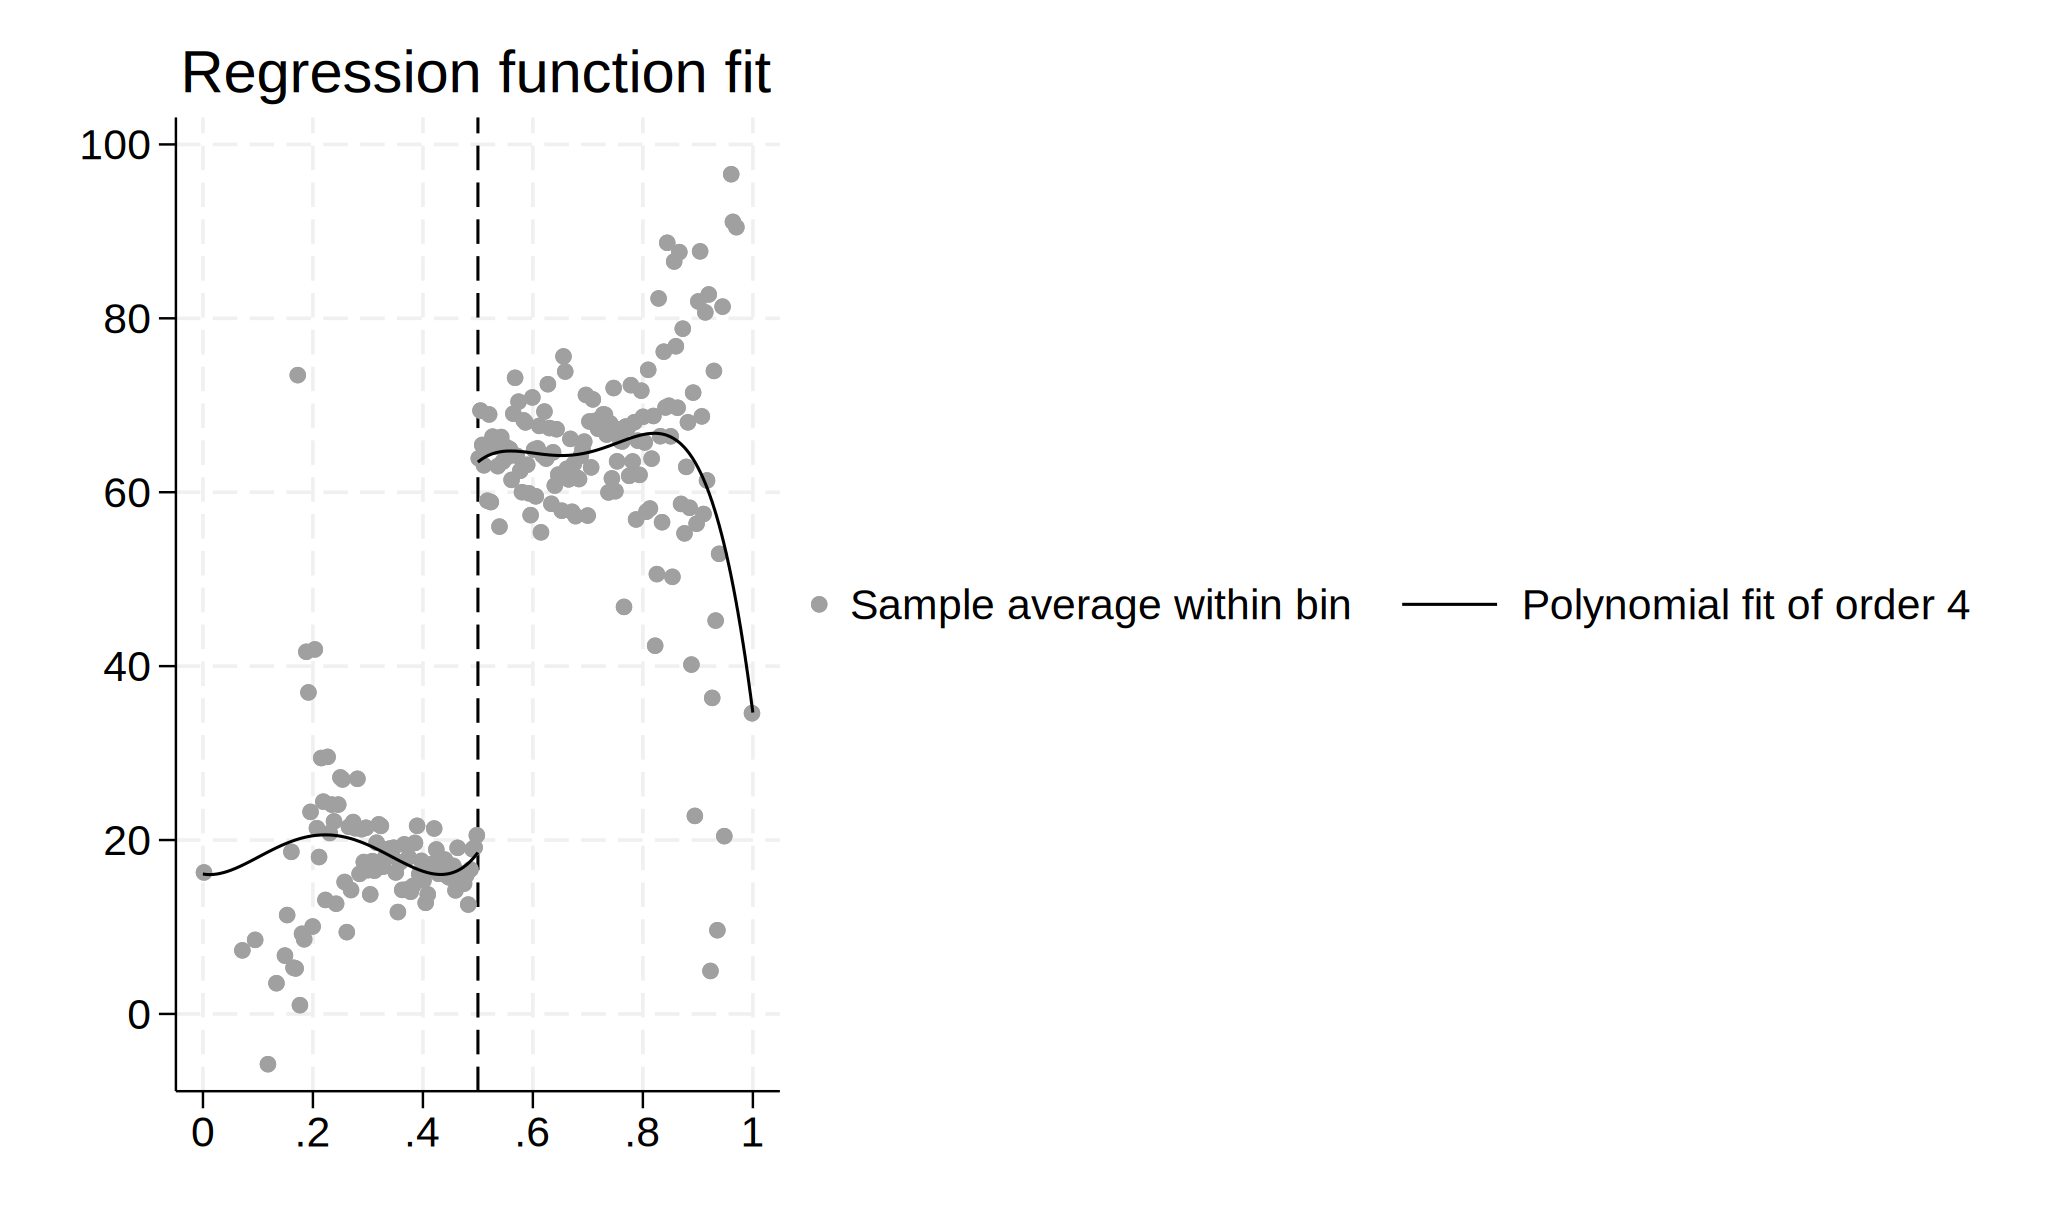

In [57]:
%%stata

* 6. Use rdrobust and rdplot to check if the results in the paper are close to what they should be 
// (assuming the non-parametric method gives the correct answer)


rdrobust score demvoteshare, c(0.5)
rdplot score demvoteshare, c(0.5)


. 
. * 7. Use rddensity to check if there was any manipulation around the cutoff.
. 
. rddensity demvoteshare, c(0.5) plot
Computing data-driven bandwidth selectors.

Point estimates and standard errors have been adjusted for repeated observation
> s.
(Use option nomasspoints to suppress this adjustment.)

RD Manipulation test using local polynomial density estimation.

     c =     0.500 | Left of c  Right of c          Number of obs =        1357
> 7
-------------------+----------------------          Model         = unrestricte
> d
     Number of obs |      5480        8097          BW method     =         com
> b
Eff. Number of obs |      1994        2250          Kernel        =   triangula
> r
    Order est. (p) |         2           2          VCE method    =    jackknif
> e
    Order bias (q) |         3           3
       BW est. (h) |     0.081       0.103

Running variable: demvoteshare.
------------------------------------------
            Method |      T          P>|T|
-

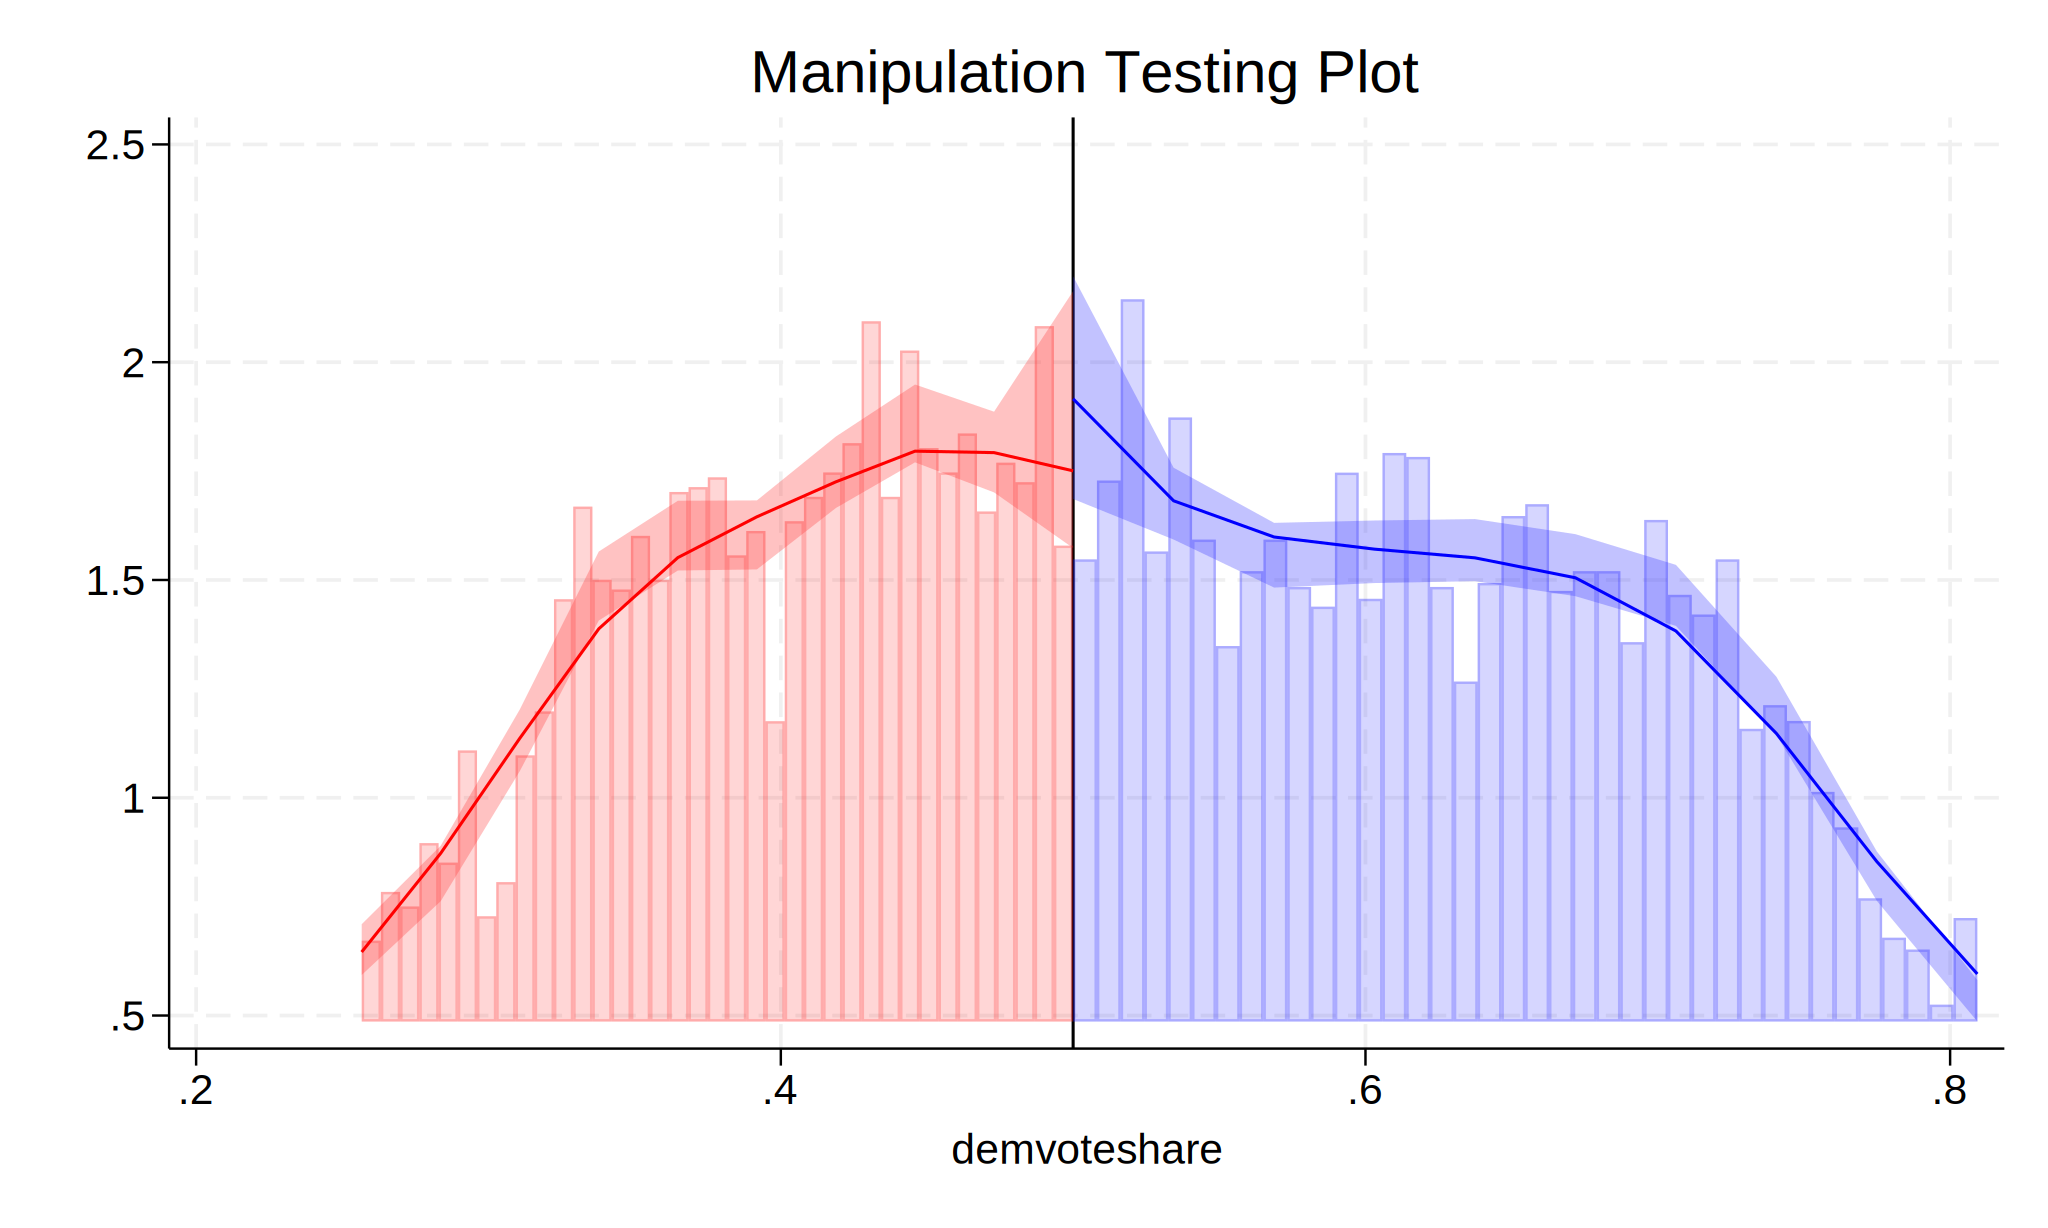

In [58]:
%%stata

* 7. Use rddensity to check if there was any manipulation around the cutoff.

rddensity demvoteshare, c(0.5) plot


## Just because


. 
. *ssc install cmogram
. cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) qfitci

Plotting mean of score, conditional on lagdemvoteshare.

n = 13577

Bin #1: [0,.0135101361854656] (n = 181) (mean = 18.90983436977007)
Bin #2: (.0135101361854656,.0270202723709312] (n = 0) (mean = .)
Bin #3: (.0270202723709312,.0405304085563968] (n = 0) (mean = .)
Bin #4: (.0405304085563968,.0540405447418624] (n = 0) (mean = .)
Bin #5: (.0540405447418624,.067550680927328] (n = 0) (mean = .)
Bin #6: (.067550680927328,.0810608171127936] (n = 2) (mean = 11.2350001335144)
Bin #7: (.0810608171127936,.0945709532982592] (n = 0) (mean = .)
Bin #8: (.0945709532982592,.1080810894837248] (n = 0) (mean = .)
Bin #9: (.1080810894837248,.1215912256691904] (n = 2) (mean = -1.92999997735023
> 5)
Bin #10: (.1215912256691904,.135101361854656] (n = 2) (mean = -5.77999985218048
> 1)
Bin #11: (.135101361854656,.1486114980401216] (n = 4) (mean = 6.159999862313271
> )
Bin #12: (.1486114980401216,.1621216342255872] (

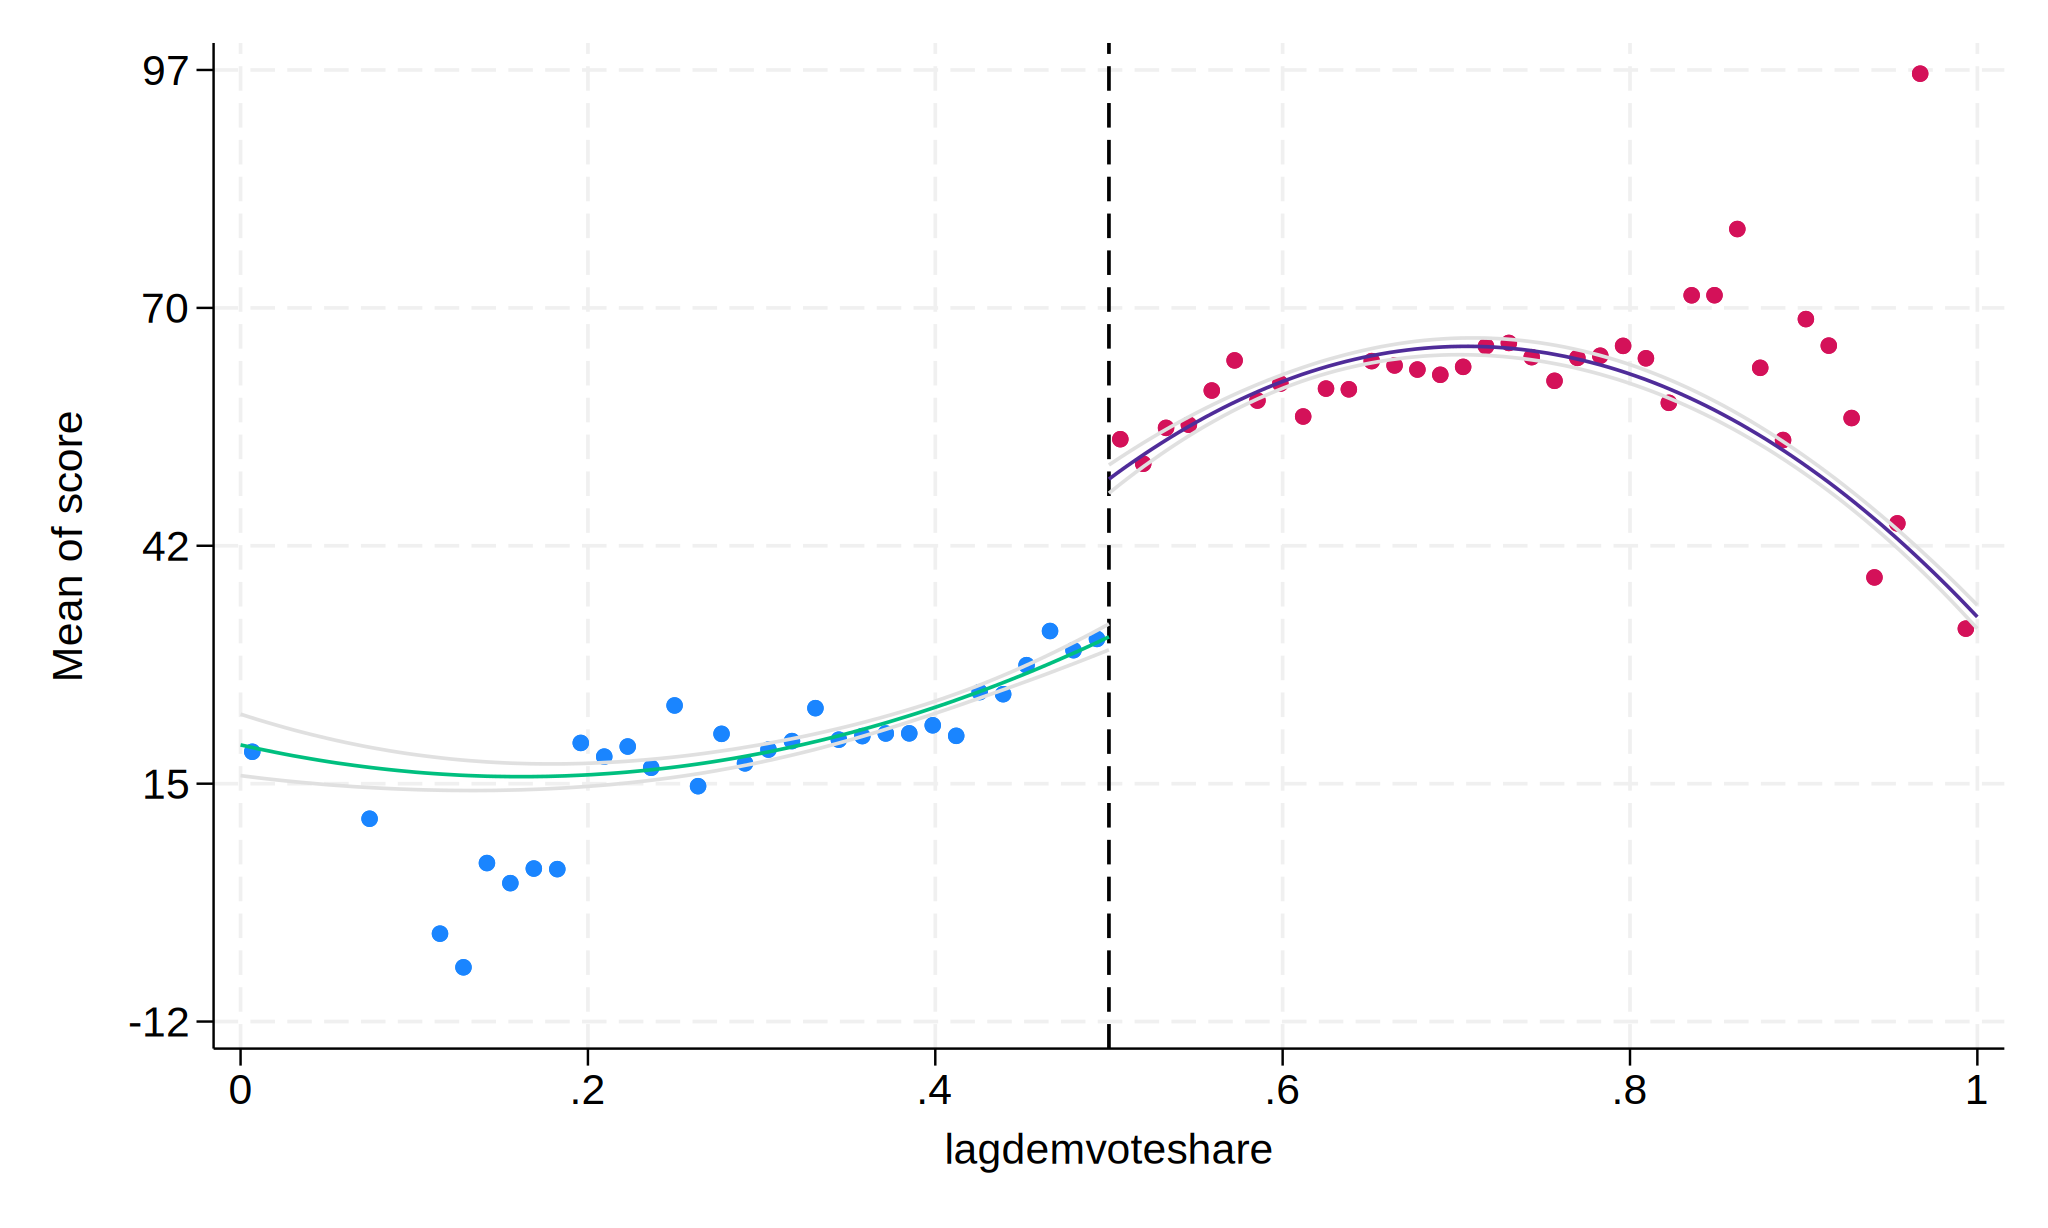

In [59]:
%%stata

*ssc install cmogram
cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) qfitci



. 
. 
. cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) lfit

Plotting mean of score, conditional on lagdemvoteshare.

n = 13577

Bin #1: [0,.0135101361854656] (n = 181) (mean = 18.90983436977007)
Bin #2: (.0135101361854656,.0270202723709312] (n = 0) (mean = .)
Bin #3: (.0270202723709312,.0405304085563968] (n = 0) (mean = .)
Bin #4: (.0405304085563968,.0540405447418624] (n = 0) (mean = .)
Bin #5: (.0540405447418624,.067550680927328] (n = 0) (mean = .)
Bin #6: (.067550680927328,.0810608171127936] (n = 2) (mean = 11.2350001335144)
Bin #7: (.0810608171127936,.0945709532982592] (n = 0) (mean = .)
Bin #8: (.0945709532982592,.1080810894837248] (n = 0) (mean = .)
Bin #9: (.1080810894837248,.1215912256691904] (n = 2) (mean = -1.92999997735023
> 5)
Bin #10: (.1215912256691904,.135101361854656] (n = 2) (mean = -5.77999985218048
> 1)
Bin #11: (.135101361854656,.1486114980401216] (n = 4) (mean = 6.159999862313271
> )
Bin #12: (.1486114980401216,.1621216342255872] (n = 8) (mean = 3.85749

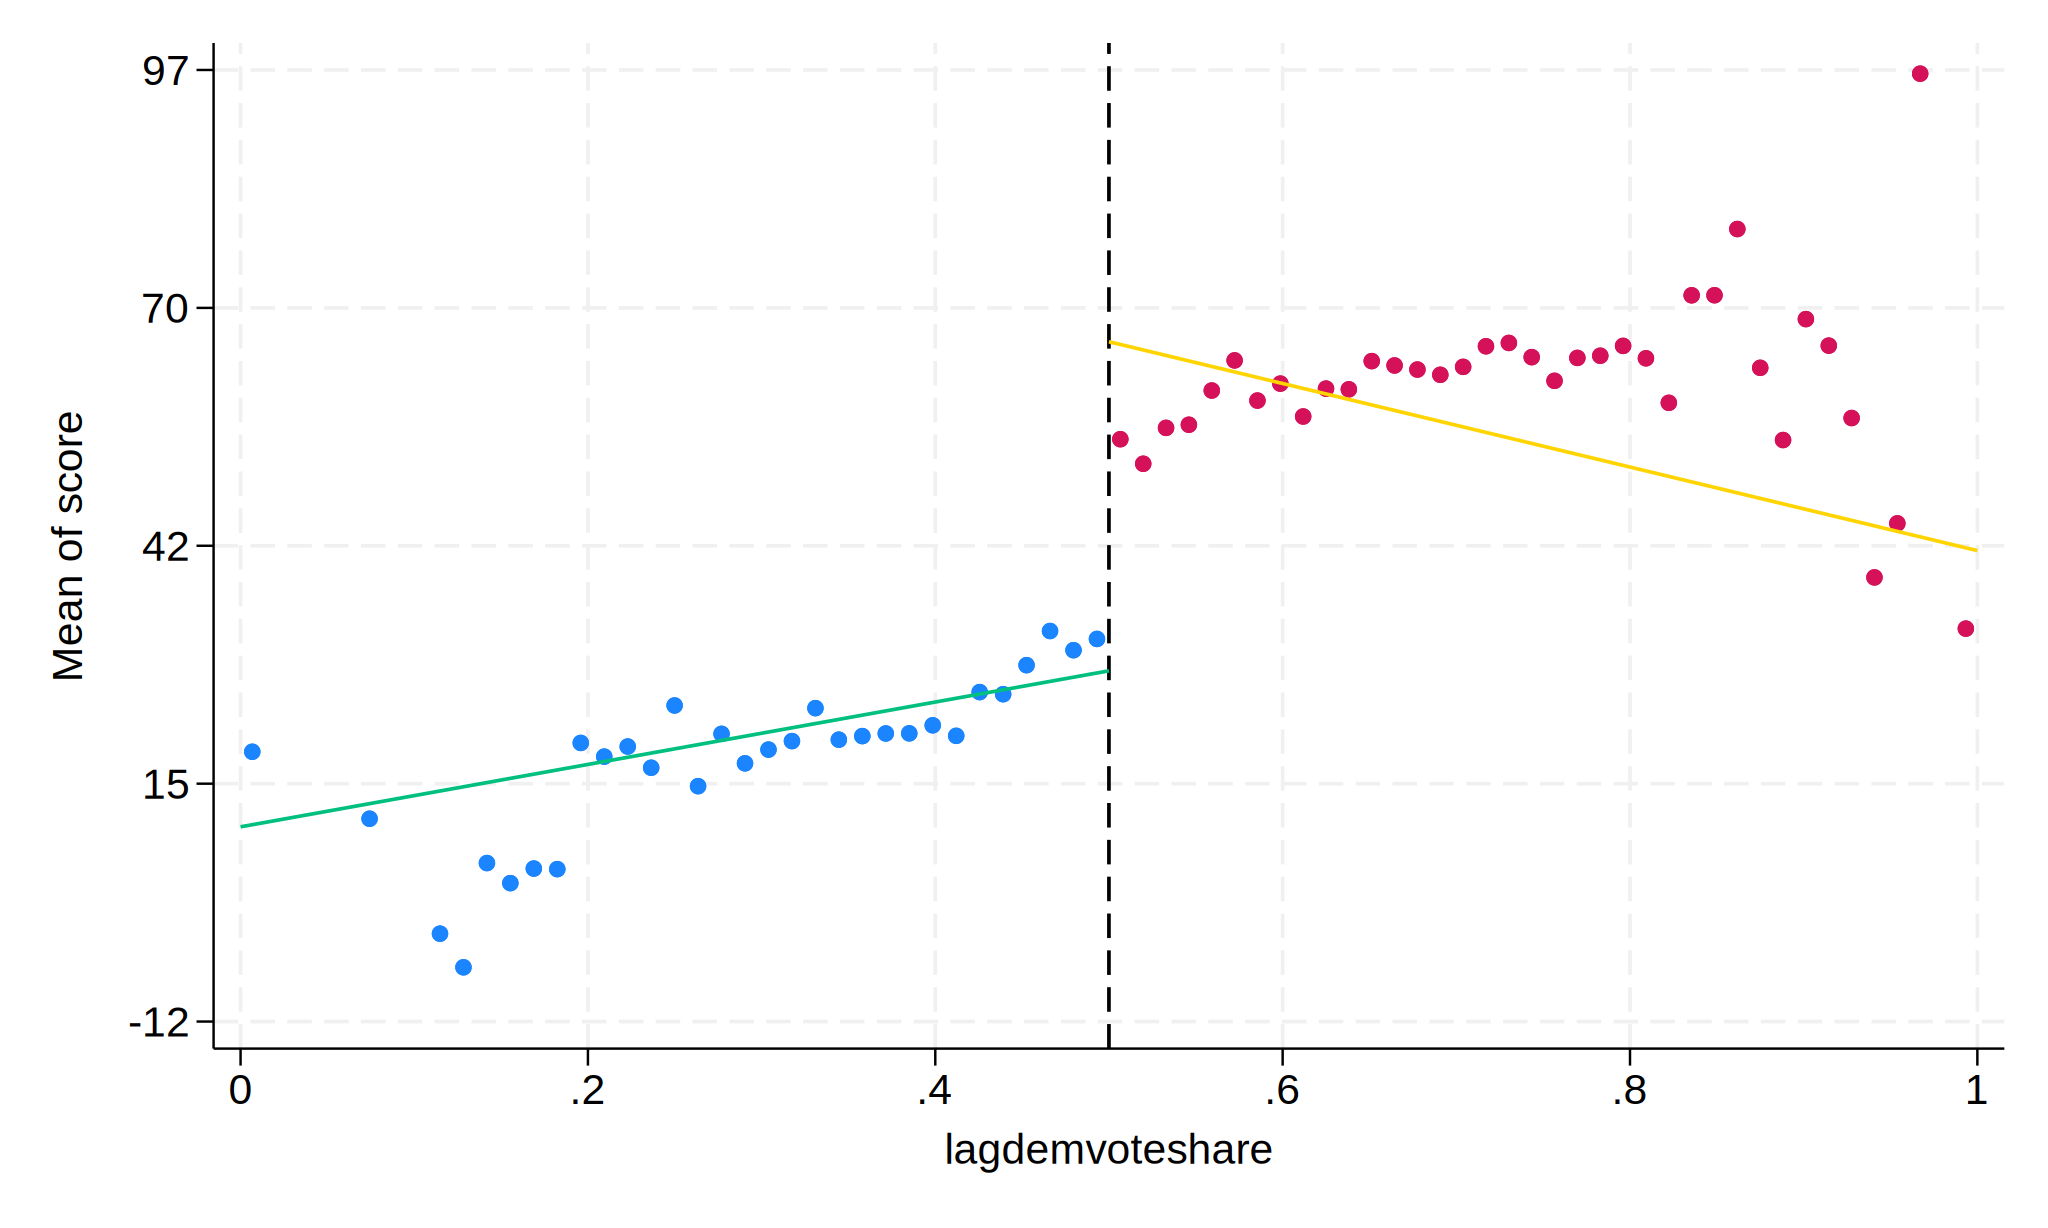

In [60]:
%%stata


cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) lfit



. 
. cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) lowess

Plotting mean of score, conditional on lagdemvoteshare.

n = 13577

Bin #1: [0,.0135101361854656] (n = 181) (mean = 18.90983436977007)
Bin #2: (.0135101361854656,.0270202723709312] (n = 0) (mean = .)
Bin #3: (.0270202723709312,.0405304085563968] (n = 0) (mean = .)
Bin #4: (.0405304085563968,.0540405447418624] (n = 0) (mean = .)
Bin #5: (.0540405447418624,.067550680927328] (n = 0) (mean = .)
Bin #6: (.067550680927328,.0810608171127936] (n = 2) (mean = 11.2350001335144)
Bin #7: (.0810608171127936,.0945709532982592] (n = 0) (mean = .)
Bin #8: (.0945709532982592,.1080810894837248] (n = 0) (mean = .)
Bin #9: (.1080810894837248,.1215912256691904] (n = 2) (mean = -1.92999997735023
> 5)
Bin #10: (.1215912256691904,.135101361854656] (n = 2) (mean = -5.77999985218048
> 1)
Bin #11: (.135101361854656,.1486114980401216] (n = 4) (mean = 6.159999862313271
> )
Bin #12: (.1486114980401216,.1621216342255872] (n = 8) (mean = 3.857499

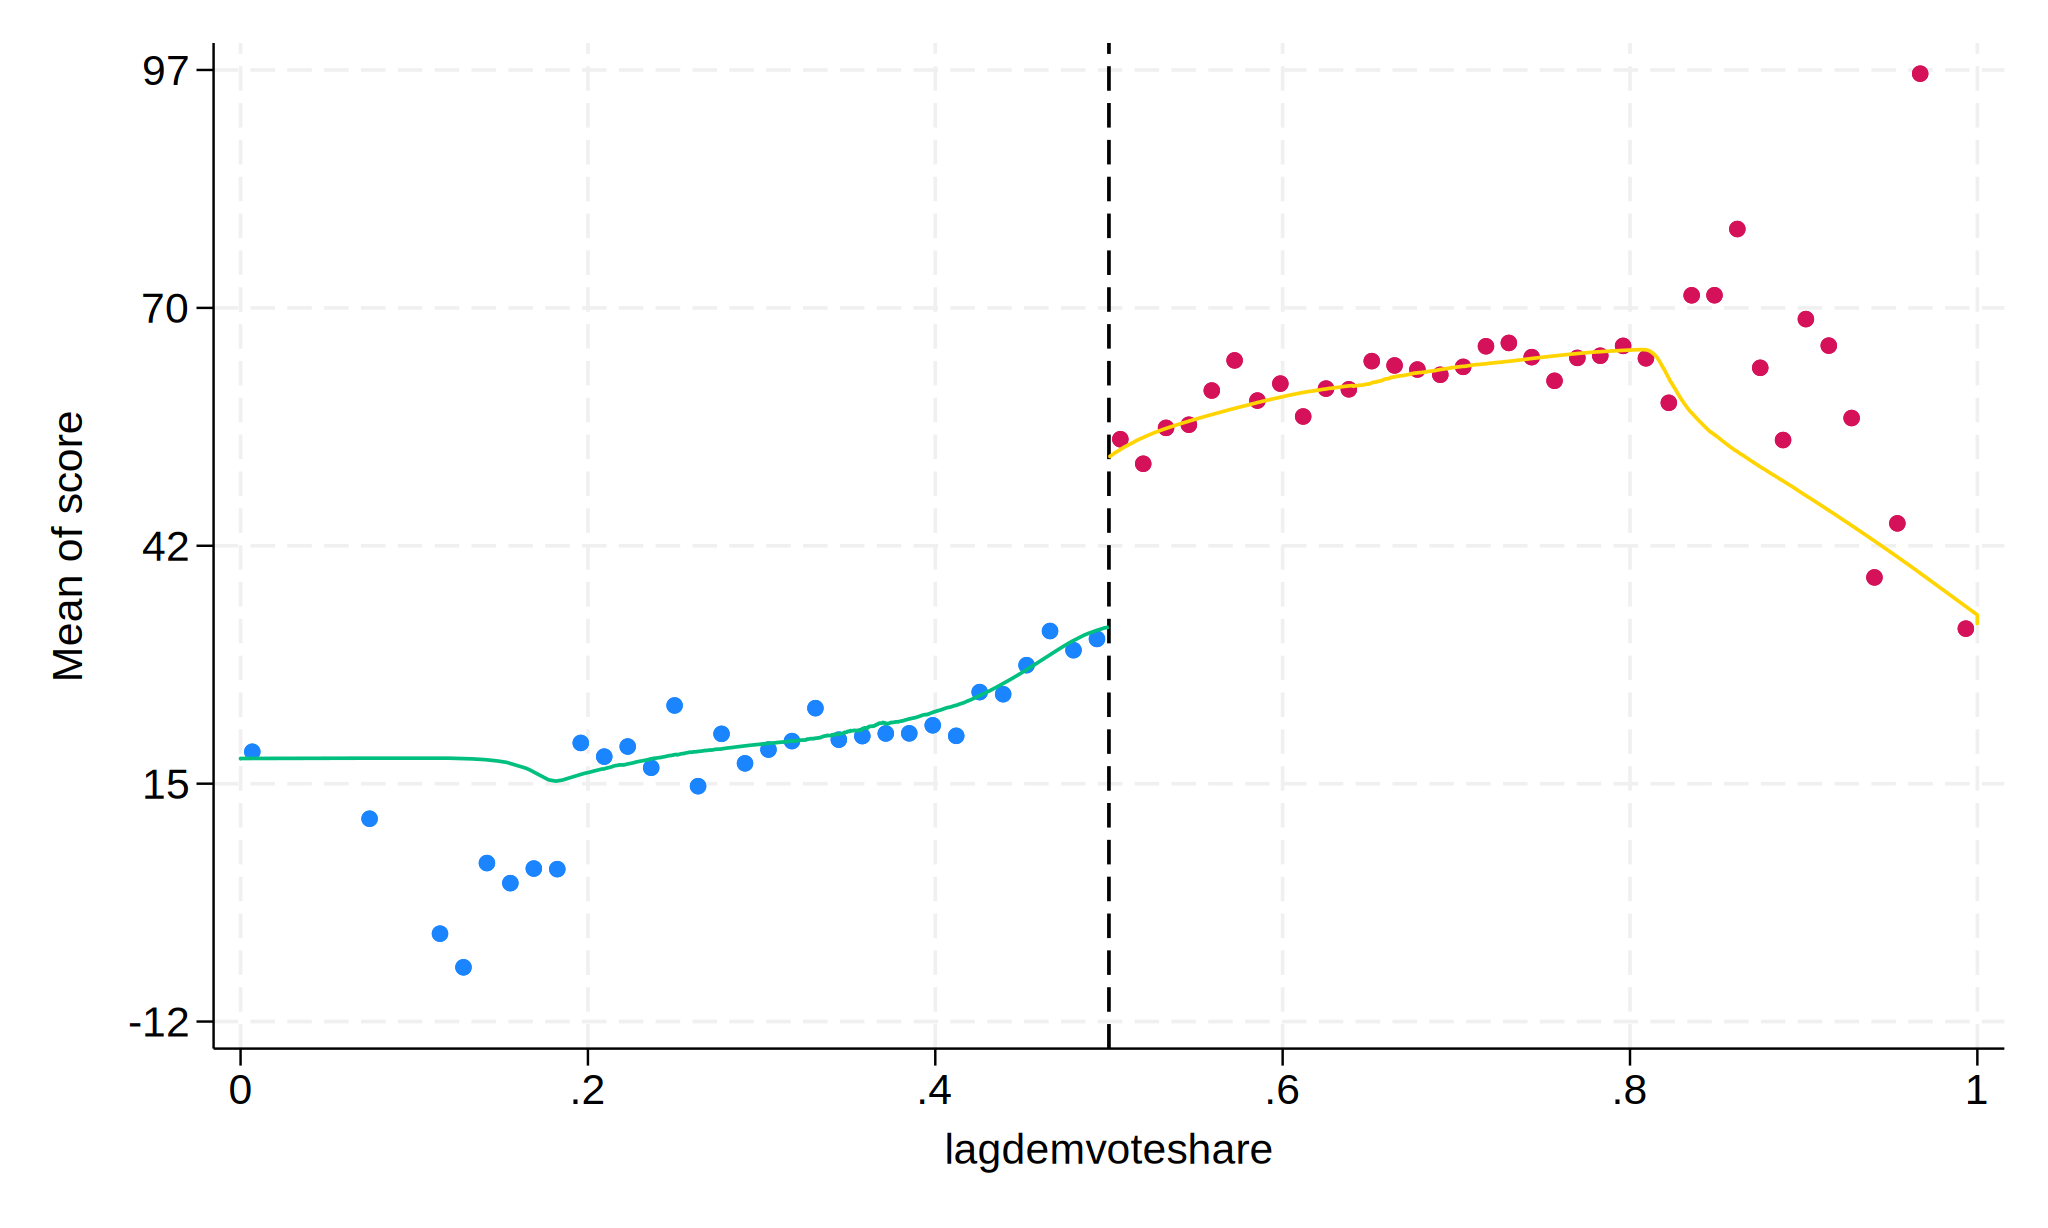

In [61]:
%%stata

cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) lowess